In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from skew_correction.data import DatasetClass, MyDataModule, plot_random_images
from skew_correction.model import MyModelModule, TimmClassifier
from skew_correction.constants import root_dir

import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime
from pytz import timezone  # This library helps you get the timezone if needed

## data

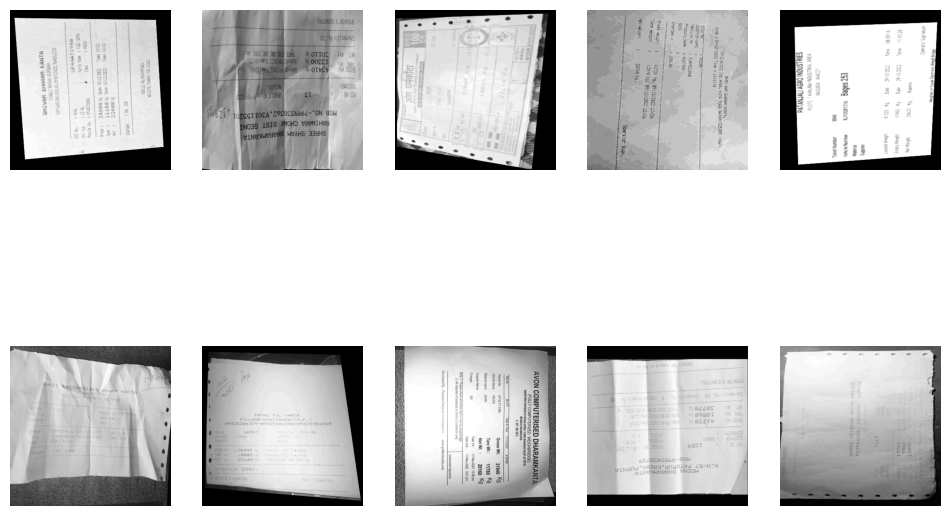

In [38]:
## load dataset
dataset = DatasetClass("/home/deepam_minda_farmart_co/fmt/skew_correction/data/train_data.csv", split='train')
plot_random_images(dataset)
pl_data = MyDataModule(dataset, train_bs=8, val_bs=8)

In [39]:
## check data sizes
pl_data.setup()
tdl = pl_data.train_dataloader()
vdl = pl_data.val_dataloader()
print(f"len of dataloader = {len(tdl)}, batchsize = {tdl.batch_size} \ntotal samples = {len(tdl)*tdl.batch_size}")
print(f"len of dataloader = {len(vdl)}, batchsize = {vdl.batch_size} \ntotal samples = {len(vdl)*vdl.batch_size}")

len of dataloader = 44, batchsize = 8 
total samples = 352
len of dataloader = 11, batchsize = 8 
total samples = 88


## train


In [40]:
## load model

lr = 0.0001
loss_fn = torch.nn.CrossEntropyLoss()
model_string = 'resnet18'

model = TimmClassifier(model_string)
pl_model = MyModelModule(model, loss_fn, lr)

In [41]:
verbose=False

# Get the current date and time in a specific format
current_date = datetime.now(timezone('Asia/Kolkata')).strftime('%Y-%m-%d')

tb_logger = TensorBoardLogger(
    save_dir=os.path.join(root_dir, 'logs'), 
    name=f"{current_date}-{model_string}-lr{lr}-bs{tdl.batch_size}-"
)

trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=200, 
        logger=tb_logger, 
        log_every_n_steps=1, 
        limit_train_batches=None, 
        limit_val_batches=None,
        enable_checkpointing=True,
        # auto_lr_find=True
    )
trainer.fit(pl_model, datamodule=pl_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/deepam_minda_farmart_co/fmt/skew_correction/logs/2023-07-30-resnet18-lr0.0001-bs8-



  | Name    | Type             | Params
---------------------------------------------
0 | model   | TimmClassifier   | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

output [1, 1, 2, 1, 3, 1, 0, 1], label tensor([0, 3, 1, 2, 2, 1, 1, 2])
output [3, 1, 1, 1, 1, 1, 1, 1], label tensor([0, 3, 2, 0, 2, 1, 0, 2])
output [1, 1, 3, 1, 1, 1, 1, 0], label tensor([1, 1, 1, 1, 2, 0, 3, 0])
output [1, 1, 2, 1, 1, 1, 1, 1], label tensor([3, 3, 0, 3, 3, 0, 1, 3])
output [3, 1, 1, 1, 1, 1, 1, 1], label tensor([3, 1, 3, 0, 1, 2, 0, 3])
output [1, 1, 3, 1, 1, 1, 1, 1], label tensor([2, 1, 0, 3, 3, 3, 3, 2])
output [1, 1, 1, 1, 1, 1, 1, 1], label tensor([2, 0, 3, 0, 2, 3, 2, 1])
output [1, 1, 1, 1, 2, 1, 1, 1], label tensor([1, 0, 0, 1, 3, 3, 3, 1])
output [1, 3, 1, 1, 1, 1, 1, 1], label tensor([2, 1, 1, 1, 0, 3, 0, 3])
output [1, 3, 1, 1, 1, 1, 1, 1], label tensor([0, 3, 1, 2, 3, 1, 1, 2])
output [1, 1, 3, 1, 1, 1, 1, 1], label tensor([1, 0, 3, 1, 1, 0, 1, 2])
output [1, 2, 1, 1, 1, 1, 1, 1], label tensor([2, 0, 1, 3, 0, 1, 0, 0])
output [3, 1, 1, 1, 1, 1, 3, 1], label tensor([1, 1, 0, 3, 0, 2, 3, 2])
output [1, 1, 3, 1, 1, 1, 1, 1], label tensor([1, 1, 3, 2, 2, 1,

Validation: 0it [00:00, ?it/s]

output [2, 1, 1, 0, 1, 3, 1, 1], label tensor([0, 3, 1, 2, 2, 1, 1, 2])
output [2, 1, 1, 1, 2, 1, 1, 1], label tensor([0, 3, 2, 0, 2, 1, 0, 2])
output [1, 1, 1, 1, 2, 1, 3, 2], label tensor([1, 1, 1, 1, 2, 0, 3, 0])
output [3, 1, 2, 1, 1, 2, 1, 3], label tensor([3, 3, 0, 3, 3, 0, 1, 3])
output [1, 1, 1, 1, 1, 2, 1, 1], label tensor([3, 1, 3, 0, 1, 2, 0, 3])
output [2, 1, 2, 1, 3, 3, 1, 2], label tensor([2, 1, 0, 3, 3, 3, 3, 2])
output [2, 2, 1, 1, 2, 1, 2, 1], label tensor([2, 0, 3, 0, 2, 3, 2, 1])
output [1, 0, 1, 1, 3, 2, 1, 1], label tensor([1, 0, 0, 1, 3, 3, 3, 1])
output [2, 3, 1, 3, 2, 1, 2, 1], label tensor([2, 1, 1, 1, 0, 3, 0, 3])
output [1, 3, 1, 2, 3, 1, 3, 2], label tensor([0, 3, 1, 2, 3, 1, 1, 2])
output [1, 2, 3, 1, 1, 2, 1, 2], label tensor([1, 0, 3, 1, 1, 0, 1, 2])
output [2, 2, 1, 3, 2, 1, 1, 0], label tensor([2, 0, 1, 3, 0, 1, 0, 0])
output [3, 3, 2, 3, 0, 2, 1, 2], label tensor([1, 1, 0, 3, 0, 2, 3, 2])
output [1, 3, 3, 2, 2, 1, 1, 2], label tensor([1, 1, 3, 2, 2, 1,

Validation: 0it [00:00, ?it/s]

output [2, 1, 1, 0, 2, 1, 3, 2], label tensor([0, 3, 1, 2, 2, 1, 1, 2])
output [0, 3, 1, 1, 2, 1, 1, 2], label tensor([0, 3, 2, 0, 2, 1, 0, 2])
output [1, 1, 1, 3, 2, 2, 3, 3], label tensor([1, 1, 1, 1, 2, 0, 3, 0])
output [1, 2, 2, 2, 3, 2, 1, 3], label tensor([3, 3, 0, 3, 3, 0, 1, 3])
output [1, 1, 1, 2, 1, 2, 2, 1], label tensor([3, 1, 3, 0, 1, 2, 0, 3])
output [2, 1, 2, 1, 3, 3, 1, 2], label tensor([2, 1, 0, 3, 3, 3, 3, 2])
output [2, 2, 1, 2, 2, 3, 2, 1], label tensor([2, 0, 3, 0, 2, 3, 2, 1])
output [1, 2, 2, 1, 1, 3, 3, 1], label tensor([1, 0, 0, 1, 3, 3, 3, 1])
output [2, 3, 1, 3, 2, 3, 2, 1], label tensor([2, 1, 1, 1, 0, 3, 0, 3])
output [2, 3, 1, 2, 3, 1, 1, 2], label tensor([0, 3, 1, 2, 3, 1, 1, 2])
output [1, 2, 3, 1, 1, 2, 1, 2], label tensor([1, 0, 3, 1, 1, 0, 1, 2])
output [2, 2, 1, 3, 2, 1, 2, 0], label tensor([2, 0, 1, 3, 0, 1, 0, 0])
output [3, 3, 2, 3, 2, 2, 1, 2], label tensor([1, 1, 0, 3, 0, 2, 3, 2])
output [1, 1, 3, 2, 2, 1, 3, 2], label tensor([1, 1, 3, 2, 2, 1,

Validation: 0it [00:00, ?it/s]

output [2, 3, 1, 0, 2, 1, 3, 2], label tensor([0, 3, 1, 2, 2, 1, 1, 2])
output [2, 3, 2, 2, 2, 1, 2, 2], label tensor([0, 3, 2, 0, 2, 1, 0, 2])
output [1, 1, 1, 1, 2, 2, 3, 2], label tensor([1, 1, 1, 1, 2, 0, 3, 0])
output [1, 3, 2, 3, 3, 2, 1, 3], label tensor([3, 3, 0, 3, 3, 0, 1, 3])
output [3, 1, 2, 2, 1, 2, 2, 3], label tensor([3, 1, 3, 0, 1, 2, 0, 3])
output [2, 1, 2, 1, 3, 3, 3, 2], label tensor([2, 1, 0, 3, 3, 3, 3, 2])
output [2, 2, 3, 2, 2, 3, 2, 1], label tensor([2, 0, 3, 0, 2, 3, 2, 1])
output [1, 2, 2, 1, 3, 3, 3, 1], label tensor([1, 0, 0, 1, 3, 3, 3, 1])
output [2, 3, 1, 1, 2, 3, 2, 3], label tensor([2, 1, 1, 1, 0, 3, 0, 3])
output [2, 3, 1, 2, 3, 3, 3, 2], label tensor([0, 3, 1, 2, 3, 1, 1, 2])
output [1, 2, 1, 1, 1, 2, 1, 2], label tensor([1, 0, 3, 1, 1, 0, 1, 2])
output [2, 2, 3, 3, 2, 1, 2, 2], label tensor([2, 0, 1, 3, 0, 1, 0, 0])
output [1, 3, 2, 1, 2, 2, 3, 2], label tensor([1, 1, 0, 3, 0, 2, 3, 2])
output [1, 1, 3, 2, 2, 1, 3, 2], label tensor([1, 1, 3, 2, 2, 1,

Validation: 0it [00:00, ?it/s]

output [2, 3, 1, 2, 2, 3, 1, 2], label tensor([0, 3, 1, 2, 2, 1, 1, 2])
output [2, 3, 2, 2, 2, 1, 2, 2], label tensor([0, 3, 2, 0, 2, 1, 0, 2])
output [2, 1, 1, 3, 2, 2, 3, 2], label tensor([1, 1, 1, 1, 2, 0, 3, 0])
output [1, 1, 2, 1, 3, 2, 1, 3], label tensor([3, 3, 0, 3, 3, 0, 1, 3])
output [1, 1, 1, 2, 1, 2, 2, 3], label tensor([3, 1, 3, 0, 1, 2, 0, 3])
output [2, 1, 2, 1, 1, 3, 1, 2], label tensor([2, 1, 0, 3, 3, 3, 3, 2])
output [2, 2, 3, 2, 2, 3, 2, 1], label tensor([2, 0, 3, 0, 2, 3, 2, 1])
output [1, 2, 2, 1, 3, 3, 3, 1], label tensor([1, 0, 0, 1, 3, 3, 3, 1])
output [2, 3, 1, 1, 2, 3, 2, 3], label tensor([2, 1, 1, 1, 0, 3, 0, 3])
output [0, 3, 1, 2, 3, 1, 1, 2], label tensor([0, 3, 1, 2, 3, 1, 1, 2])
output [1, 2, 1, 3, 1, 2, 1, 2], label tensor([1, 0, 3, 1, 1, 0, 1, 2])
output [2, 2, 3, 3, 2, 1, 2, 2], label tensor([2, 0, 1, 3, 0, 1, 0, 0])
output [3, 3, 2, 3, 2, 2, 3, 2], label tensor([1, 1, 0, 3, 0, 2, 3, 2])
output [1, 1, 3, 2, 2, 1, 1, 2], label tensor([1, 1, 3, 2, 2, 1,

Validation: 0it [00:00, ?it/s]

output [2, 3, 1, 2, 2, 1, 1, 2], label tensor([0, 3, 1, 2, 2, 1, 1, 2])
output [2, 3, 2, 2, 2, 1, 2, 2], label tensor([0, 3, 2, 0, 2, 1, 0, 2])
output [1, 1, 1, 3, 2, 2, 3, 2], label tensor([1, 1, 1, 1, 2, 0, 3, 0])
output [1, 1, 2, 1, 3, 2, 1, 3], label tensor([3, 3, 0, 3, 3, 0, 1, 3])
output [3, 1, 1, 2, 1, 2, 2, 1], label tensor([3, 1, 3, 0, 1, 2, 0, 3])
output [2, 1, 2, 1, 3, 3, 1, 2], label tensor([2, 1, 0, 3, 3, 3, 3, 2])
output [2, 0, 3, 2, 2, 3, 2, 1], label tensor([2, 0, 3, 0, 2, 3, 2, 1])
output [1, 2, 2, 1, 3, 3, 3, 1], label tensor([1, 0, 0, 1, 3, 3, 3, 1])
output [2, 3, 1, 1, 2, 3, 2, 3], label tensor([2, 1, 1, 1, 0, 3, 0, 3])
output [2, 3, 1, 2, 3, 1, 1, 2], label tensor([0, 3, 1, 2, 3, 1, 1, 2])
output [1, 2, 3, 1, 1, 2, 1, 2], label tensor([1, 0, 3, 1, 1, 0, 1, 2])
output [2, 2, 1, 3, 2, 1, 0, 2], label tensor([2, 0, 1, 3, 0, 1, 0, 0])
output [3, 1, 2, 3, 2, 2, 3, 2], label tensor([1, 1, 0, 3, 0, 2, 3, 2])
output [1, 1, 3, 2, 2, 1, 3, 2], label tensor([1, 1, 3, 2, 2, 1,

'2023-07-30'